## Goal: use of everything we've learned about APIs, databases, and Object-Oriented Programming to Extract, Transform, and Load (or ETL, for short) some data from a SQL database into a MongoDB Database.

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

- 1. The name of the team
- 2. The total number of goals scored by the team during the 2011 season
- 3. The total number of wins the team earned during the 2011 season
- 4. A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
- 5. The team's win percentage on days where it was raining during games in the 2011 season.


Using Object-Oriented Programming is a requirement for this project--you must create at least 2 separate, well structured classes in your solution! Although it may seem easier to "just start coding", this is a classic beginner's mistake. Instead, think about separating out the different functionalities you'll need to reach your goal, and then build classes to handle each. For instance, at minimum, you'll need to:

- Query the SQL database
- Calculate summary statistics
- Get the weather data from the DarkSky API
- Load the data into MongoDB

We strongly recommend you consider creating separate classes for handling at least some of these of these tasks. Be sure to plan the inputs, outputs, and methods for each class before you begin coding!



## Inspect Database.sqlite

In [174]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pandas
import re
import datetime
import time
import re
import json
from bs4 import BeautifulSoup
%matplotlib inline

In [6]:
conn = sqlite3.connect('database.sqlite.db')
c = conn.cursor()

In [7]:
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('sqlite_sequence',), ('Matches',), ('Teams_in_Matches',), ('Teams',), ('Unique_Teams',), ('results',)]


In [8]:
tables = list(c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall())
tables

[('sqlite_sequence',),
 ('Matches',),
 ('Teams_in_Matches',),
 ('Teams',),
 ('Unique_Teams',),
 ('results',)]

In [9]:
c.execute("SELECT name, type FROM sqlite_master;")
print(c.fetchall())

[('sqlite_sequence', 'table'), ('Matches', 'table'), ('sqlite_autoindex_Matches_1', 'index'), ('Teams_in_Matches', 'table'), ('Teams', 'table'), ('Unique_Teams', 'table'), ('FlatView_Chrono_TeamOrder_Reduced', 'view'), ('FlatView_Advanced', 'view'), ('FlatView', 'view'), ('results', 'table')]


In [10]:
c.execute('''select * from sqlite_sequence;''')
c.description


(('name', None, None, None, None, None, None),
 ('seq', None, None, None, None, None, None))

In [11]:
c.execute('''select * from sqlite_sequence;''')
df1 = pd.DataFrame(c.fetchall())
df1.columns = [x[0] for x in c.description]

In [61]:
df1

,name,seq
0,Matches,46774
1,Unique_Teams,128


In [12]:
c.execute('''select * from Teams_in_Matches;''')
df2 = pd.DataFrame(c.fetchall())
df2.columns = [x[0] for x in c.description]
print(len(df2))
df2.head()

49148


,Match_ID,Unique_Team_ID
0,1,26
1,1,46
2,2,26
3,2,42
4,3,26


Table: Teams_in_Matches

- Match_ID (int): Unique match ID
- Unique_Team_ID (int): Unique team ID (This table is used to easily retrieve each match a given team has played in)


In [13]:
c.execute('''select * from Teams;''')
df3 = pd.DataFrame(c.fetchall())
df3.columns = [x[0] for x in c.description]
print(len(df3))
df3.head()


468


,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2017,Bayern Munich,27,26,15,597950000,22150000,75000
1,2017,Dortmund,33,25,18,416730000,12630000,81359
2,2017,Leverkusen,31,24,15,222600000,7180000,30210
3,2017,RB Leipzig,30,23,15,180130000,6000000,42959
4,2017,Schalke 04,29,24,17,179550000,6190000,62271


Table: Teams

- Season (str): Football season for which the data is valid
- TeamName (str): Name of the team the data concerns
- KaderHome (str): Number of Players in the squad
- AvgAgeHome (str): Average age of players
- ForeignPlayersHome (str): Number of foreign players (non-German, non-English respectively) playing for the team
- OverallMarketValueHome (str): Overall market value of the team pre-season in EUR (based on data from transfermarkt.de)
- AvgMarketValueHome (str): Average market value (per player) of the team pre-season in EUR (based on data from transfermarkt.de)
- StadiumCapacity (str): Maximum stadium capacity of the team's home stadium


In [14]:
c.execute('''select * from Unique_Teams;''')
df4 = pd.DataFrame(c.fetchall())
df4.columns = [x[0] for x in c.description]
print(len(df4))
df4.head()


128


,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2
2,Leverkusen,3
3,RB Leipzig,4
4,Schalke 04,5


Table: Unique Teams

- TeamName (str): Name of a team
- Unique_Team_ID (int): Unique identifier for each team


In [15]:
c.execute('''select * from Matches;''').description


(('Match_ID', None, None, None, None, None, None),
 ('Div', None, None, None, None, None, None),
 ('Season', None, None, None, None, None, None),
 ('Date', None, None, None, None, None, None),
 ('HomeTeam', None, None, None, None, None, None),
 ('AwayTeam', None, None, None, None, None, None),
 ('FTHG', None, None, None, None, None, None),
 ('FTAG', None, None, None, None, None, None),
 ('FTR', None, None, None, None, None, None))

Table: Matches

- Match_ID (int): unique ID per match
- Div (str): identifies the division the match was played in (D1 = Bundesliga, D2 = Bundesliga 2, E0 = English Premier League)
- Season (int): Season the match took place in (usually covering the period of August till May of the following year)
- Date (str): Date of the match
- HomeTeam (str): Name of the home team
- AwayTeam (str): Name of the away team
- FTHG (int) (Full Time Home Goals): Number of goals scored by the home team
- FTAG (int) (Full Time Away Goals): Number of goals scored by the away team
- FTR (str) (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)

In [153]:
c.execute('''select * from Matches where season = 2011 order by date;''')
dfm = pd.DataFrame(c.fetchall())
dfm.columns = [x[0] for x in c.description]
print(len(dfm))
dfm.head(100)

992


,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H
5,1146,D2,2011,2011-07-17,Karlsruhe,Duisburg,3,2,H
6,1442,D2,2011,2011-07-17,Braunschweig,Munich 1860,3,1,H
7,1602,D2,2011,2011-07-17,Hansa Rostock,Paderborn,1,2,A
8,1360,D2,2011,2011-07-18,Fortuna Dusseldorf,Bochum,2,0,H
9,1505,D2,2011,2011-07-22,Duisburg,Cottbus,1,2,A


## Date data for API

In [419]:
c.execute('''select Date from Matches where season = 2011 order by date;''')
dfd = pd.DataFrame(c.fetchall())
dfd.columns = [x[0] for x in c.description]
print(len(dfd))
#dfd.head(100)

992


In [420]:
dfdate = pd.DataFrame(dfd.Date.unique())

In [421]:
dfdate.columns = ["Date"]

In [422]:
dfdate.head()

,Date
0,2011-07-15
1,2011-07-16
2,2011-07-17
3,2011-07-18
4,2011-07-22


In [19]:
df[df['HomeTeam']== 'Aachen']

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
15,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,A
46,1507,D2,2011,2011-08-13,Aachen,Cottbus,0,2,A
102,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D
167,1529,D2,2011,2011-09-18,Aachen,Greuther Furth,0,0,D
206,1662,D2,2011,2011-09-30,Aachen,Frankfurt FSV,1,3,A
281,1682,D2,2011,2011-10-23,Aachen,Ingolstadt,3,1,H
335,1148,D2,2011,2011-11-06,Aachen,Duisburg,2,2,D
418,1446,D2,2011,2011-12-04,Aachen,Munich 1860,2,2,D
449,1595,D2,2011,2011-12-11,Aachen,Erzgebirge Aue,1,1,D
580,1465,D2,2011,2012-02-04,Aachen,St Pauli,2,1,H


In [20]:
df[df['HomeTeam']== 'Aachen']['FTHG'].sum()

15

## Identify the first and last day of the 2011 season

In [21]:
c.execute('''select date from Matches where season = 2011 order by date;''').fetchone()


('2011-07-15',)

In [22]:
c.execute('''select date from Matches where season = 2011 order by date desc;''').fetchone()


('2012-05-13',)

## Identify the set of teams played in 2011

In [29]:
hometeam = set(c.execute(
    '''select distinct hometeam from Matches where season = 2011 order by hometeam;''').fetchall())
print(len(hometeam))
hometeam

56


{('Aachen',),
 ('Arsenal',),
 ('Aston Villa',),
 ('Augsburg',),
 ('Bayern Munich',),
 ('Blackburn',),
 ('Bochum',),
 ('Bolton',),
 ('Braunschweig',),
 ('Chelsea',),
 ('Cottbus',),
 ('Dortmund',),
 ('Dresden',),
 ('Duisburg',),
 ('Ein Frankfurt',),
 ('Erzgebirge Aue',),
 ('Everton',),
 ('FC Koln',),
 ('Fortuna Dusseldorf',),
 ('Frankfurt FSV',),
 ('Freiburg',),
 ('Fulham',),
 ('Greuther Furth',),
 ('Hamburg',),
 ('Hannover',),
 ('Hansa Rostock',),
 ('Hertha',),
 ('Hoffenheim',),
 ('Ingolstadt',),
 ('Kaiserslautern',),
 ('Karlsruhe',),
 ('Leverkusen',),
 ('Liverpool',),
 ("M'gladbach",),
 ('Mainz',),
 ('Man City',),
 ('Man United',),
 ('Munich 1860',),
 ('Newcastle',),
 ('Norwich',),
 ('Nurnberg',),
 ('Paderborn',),
 ('QPR',),
 ('Schalke 04',),
 ('St Pauli',),
 ('Stoke',),
 ('Stuttgart',),
 ('Sunderland',),
 ('Swansea',),
 ('Tottenham',),
 ('Union Berlin',),
 ('Werder Bremen',),
 ('West Brom',),
 ('Wigan',),
 ('Wolfsburg',),
 ('Wolves',)}

In [30]:
awayteam = set(c.execute('''select distinct awayteam from Matches where season = 2011 order by awayteam;''').fetchall())
print(len(awayteam))
awayteam

56


{('Aachen',),
 ('Arsenal',),
 ('Aston Villa',),
 ('Augsburg',),
 ('Bayern Munich',),
 ('Blackburn',),
 ('Bochum',),
 ('Bolton',),
 ('Braunschweig',),
 ('Chelsea',),
 ('Cottbus',),
 ('Dortmund',),
 ('Dresden',),
 ('Duisburg',),
 ('Ein Frankfurt',),
 ('Erzgebirge Aue',),
 ('Everton',),
 ('FC Koln',),
 ('Fortuna Dusseldorf',),
 ('Frankfurt FSV',),
 ('Freiburg',),
 ('Fulham',),
 ('Greuther Furth',),
 ('Hamburg',),
 ('Hannover',),
 ('Hansa Rostock',),
 ('Hertha',),
 ('Hoffenheim',),
 ('Ingolstadt',),
 ('Kaiserslautern',),
 ('Karlsruhe',),
 ('Leverkusen',),
 ('Liverpool',),
 ("M'gladbach",),
 ('Mainz',),
 ('Man City',),
 ('Man United',),
 ('Munich 1860',),
 ('Newcastle',),
 ('Norwich',),
 ('Nurnberg',),
 ('Paderborn',),
 ('QPR',),
 ('Schalke 04',),
 ('St Pauli',),
 ('Stoke',),
 ('Stuttgart',),
 ('Sunderland',),
 ('Swansea',),
 ('Tottenham',),
 ('Union Berlin',),
 ('Werder Bremen',),
 ('West Brom',),
 ('Wigan',),
 ('Wolfsburg',),
 ('Wolves',)}

In [31]:
hometeam - awayteam

set()

### Clean special characters

In [32]:
team = c.execute(
    '''select distinct hometeam from Matches where season = 2011 order by hometeam;''').fetchall()
print(len(team))
team

56


[('Aachen',),
 ('Arsenal',),
 ('Aston Villa',),
 ('Augsburg',),
 ('Bayern Munich',),
 ('Blackburn',),
 ('Bochum',),
 ('Bolton',),
 ('Braunschweig',),
 ('Chelsea',),
 ('Cottbus',),
 ('Dortmund',),
 ('Dresden',),
 ('Duisburg',),
 ('Ein Frankfurt',),
 ('Erzgebirge Aue',),
 ('Everton',),
 ('FC Koln',),
 ('Fortuna Dusseldorf',),
 ('Frankfurt FSV',),
 ('Freiburg',),
 ('Fulham',),
 ('Greuther Furth',),
 ('Hamburg',),
 ('Hannover',),
 ('Hansa Rostock',),
 ('Hertha',),
 ('Hoffenheim',),
 ('Ingolstadt',),
 ('Kaiserslautern',),
 ('Karlsruhe',),
 ('Leverkusen',),
 ('Liverpool',),
 ("M'gladbach",),
 ('Mainz',),
 ('Man City',),
 ('Man United',),
 ('Munich 1860',),
 ('Newcastle',),
 ('Norwich',),
 ('Nurnberg',),
 ('Paderborn',),
 ('QPR',),
 ('Schalke 04',),
 ('St Pauli',),
 ('Stoke',),
 ('Stuttgart',),
 ('Sunderland',),
 ('Swansea',),
 ('Tottenham',),
 ('Union Berlin',),
 ('Werder Bremen',),
 ('West Brom',),
 ('Wigan',),
 ('Wolfsburg',),
 ('Wolves',)]

In [291]:
teams = []
for t in team:
    newt = t[0].translate({ord(i): ''''{}'''.format(i) for i in "'"})
    teams.append(newt)
teams
# hteam[0]

['Aachen',
 'Arsenal',
 'Aston Villa',
 'Augsburg',
 'Bayern Munich',
 'Blackburn',
 'Bochum',
 'Bolton',
 'Braunschweig',
 'Chelsea',
 'Cottbus',
 'Dortmund',
 'Dresden',
 'Duisburg',
 'Ein Frankfurt',
 'Erzgebirge Aue',
 'Everton',
 'FC Koln',
 'Fortuna Dusseldorf',
 'Frankfurt FSV',
 'Freiburg',
 'Fulham',
 'Greuther Furth',
 'Hamburg',
 'Hannover',
 'Hansa Rostock',
 'Hertha',
 'Hoffenheim',
 'Ingolstadt',
 'Kaiserslautern',
 'Karlsruhe',
 'Leverkusen',
 'Liverpool',
 "M''gladbach",
 'Mainz',
 'Man City',
 'Man United',
 'Munich 1860',
 'Newcastle',
 'Norwich',
 'Nurnberg',
 'Paderborn',
 'QPR',
 'Schalke 04',
 'St Pauli',
 'Stoke',
 'Stuttgart',
 'Sunderland',
 'Swansea',
 'Tottenham',
 'Union Berlin',
 'Werder Bremen',
 'West Brom',
 'Wigan',
 'Wolfsburg',
 'Wolves']

## #1&2 Sum team goals

In [33]:
c.execute('''select FTHG from Matches where season = 2011 and hometeam = 'Aachen';''').fetchall()

[(0,),
 (2,),
 (0,),
 (1,),
 (2,),
 (0,),
 (2,),
 (2,),
 (0,),
 (0,),
 (1,),
 (0,),
 (1,),
 (0,),
 (1,),
 (3,),
 (0,)]

In [34]:
c.execute('''select sum(FTHG) from Matches where season = 2011 and hometeam = 'Aachen';''').fetchall()

[(15,)]

In [37]:
hg=[]
for t in teams:
    q = '''select sum(FTHG) from Matches where season = 2011 and hometeam = '{}';'''.format(t)
    hg.append(c.execute(q).fetchall()[0][0])
hg

[15,
 39,
 20,
 20,
 49,
 26,
 23,
 23,
 21,
 41,
 18,
 44,
 30,
 23,
 38,
 19,
 28,
 20,
 35,
 20,
 24,
 36,
 46,
 19,
 31,
 20,
 19,
 21,
 28,
 12,
 23,
 28,
 24,
 29,
 27,
 55,
 52,
 35,
 29,
 28,
 22,
 28,
 24,
 47,
 36,
 25,
 36,
 26,
 27,
 39,
 30,
 31,
 21,
 22,
 29,
 19]

In [38]:
ag=[]
for t in teams:
    q = '''select sum(FTAG) from Matches where season = 2011 and awayteam = '{}';'''.format(t)
    ag.append(c.execute(q).fetchall()[0][0])
ag

[15,
 35,
 17,
 16,
 28,
 22,
 18,
 23,
 16,
 24,
 12,
 36,
 20,
 19,
 38,
 12,
 22,
 19,
 29,
 23,
 21,
 12,
 27,
 16,
 10,
 14,
 19,
 20,
 15,
 12,
 11,
 24,
 23,
 20,
 20,
 38,
 37,
 27,
 27,
 24,
 16,
 23,
 19,
 27,
 23,
 11,
 27,
 19,
 17,
 27,
 25,
 18,
 24,
 20,
 18,
 21]

## #3 Sum team wins

In [39]:
c.execute('''select count(FTR) from Matches where season = 2011 and hometeam = 'Aachen' and FTR = 'H';''').fetchall()

[(4,)]

In [40]:
hw=[]
for t in teams:
    q = '''select count(FTR) from Matches where season = 2011 and hometeam = '{}' and FTR = 'H';'''.format(t)
    hw.append(c.execute(q).fetchall()[0][0])
hw

[4,
 12,
 4,
 6,
 14,
 6,
 7,
 4,
 6,
 12,
 4,
 14,
 8,
 8,
 11,
 5,
 10,
 5,
 11,
 3,
 6,
 10,
 14,
 3,
 10,
 3,
 4,
 4,
 6,
 2,
 8,
 8,
 6,
 9,
 7,
 18,
 15,
 10,
 11,
 7,
 6,
 9,
 7,
 13,
 12,
 7,
 10,
 7,
 8,
 13,
 11,
 8,
 6,
 5,
 10,
 3]

In [41]:
aw=[]
for t in teams:
    q = '''select count(FTR) from Matches where season = 2011 and awayteam = '{}' and FTR = 'A';'''.format(t)
    aw.append(c.execute(q).fetchall()[0][0])
aw

[2,
 9,
 3,
 2,
 9,
 2,
 3,
 6,
 4,
 6,
 4,
 11,
 4,
 2,
 9,
 3,
 5,
 3,
 5,
 4,
 4,
 4,
 6,
 5,
 2,
 2,
 3,
 6,
 2,
 2,
 1,
 7,
 8,
 8,
 2,
 10,
 13,
 7,
 8,
 5,
 6,
 8,
 3,
 7,
 6,
 4,
 5,
 4,
 4,
 7,
 3,
 3,
 7,
 6,
 3,
 2]

## #4a Sum team losses

In [42]:
hl=[]
for t in teams:
    q = '''select count(FTR) from Matches where season = 2011 and hometeam = '{}' and FTR = 'A';'''.format(t)
    hl.append(c.execute(q).fetchall()[0][0])
hl

[7,
 3,
 8,
 4,
 2,
 12,
 7,
 11,
 3,
 4,
 5,
 1,
 4,
 7,
 1,
 5,
 6,
 8,
 1,
 4,
 5,
 4,
 2,
 7,
 0,
 7,
 10,
 4,
 3,
 10,
 6,
 5,
 4,
 1,
 7,
 0,
 2,
 5,
 3,
 6,
 7,
 2,
 7,
 3,
 2,
 4,
 4,
 5,
 4,
 3,
 4,
 5,
 10,
 7,
 5,
 13]

In [43]:
al=[]
for t in teams:
    q = '''select count(FTR) from Matches where season = 2011 and awayteam = '{}' and FTR = 'H';'''.format(t)
    al.append(c.execute(q).fetchall()[0][0])
al

[8,
 7,
 6,
 8,
 5,
 11,
 10,
 11,
 6,
 6,
 10,
 2,
 9,
 8,
 5,
 10,
 6,
 12,
 3,
 9,
 9,
 10,
 2,
 7,
 10,
 10,
 7,
 9,
 10,
 9,
 13,
 5,
 10,
 7,
 6,
 5,
 3,
 6,
 8,
 9,
 9,
 5,
 14,
 7,
 6,
 11,
 7,
 10,
 11,
 6,
 10,
 9,
 7,
 10,
 11,
 10]

## #4b Save results in new table and histogram

In [47]:
teams

['Aachen',
 'Arsenal',
 'Aston Villa',
 'Augsburg',
 'Bayern Munich',
 'Blackburn',
 'Bochum',
 'Bolton',
 'Braunschweig',
 'Chelsea',
 'Cottbus',
 'Dortmund',
 'Dresden',
 'Duisburg',
 'Ein Frankfurt',
 'Erzgebirge Aue',
 'Everton',
 'FC Koln',
 'Fortuna Dusseldorf',
 'Frankfurt FSV',
 'Freiburg',
 'Fulham',
 'Greuther Furth',
 'Hamburg',
 'Hannover',
 'Hansa Rostock',
 'Hertha',
 'Hoffenheim',
 'Ingolstadt',
 'Kaiserslautern',
 'Karlsruhe',
 'Leverkusen',
 'Liverpool',
 "M''gladbach",
 'Mainz',
 'Man City',
 'Man United',
 'Munich 1860',
 'Newcastle',
 'Norwich',
 'Nurnberg',
 'Paderborn',
 'QPR',
 'Schalke 04',
 'St Pauli',
 'Stoke',
 'Stuttgart',
 'Sunderland',
 'Swansea',
 'Tottenham',
 'Union Berlin',
 'Werder Bremen',
 'West Brom',
 'Wigan',
 'Wolfsburg',
 'Wolves']

In [83]:
type(hg[1])

int

In [137]:
c.execute('''create table results (
                                 id INTEGER PRIMARY KEY,
                                 teamnames text, 
                                 homegoals integer, 
                                 awaygoals integer, 
                                 homewins integer, 
                                 awaywins integer, 
                                 homelosses integer,
                                 awaylosses integer
                                 );''')

In [134]:
c.execute('''drop table results;''')

In [132]:
for i in teams:
    c.execute('''insert into results (teamnames) values ('{}');'''.format(i)).fetchall()

In [117]:
for i,j,k,l,m,n in hg,ag,hw,aw,hl,al:
    c.execute('''insert into results (homegoals) values ('{}');'''.format(i)).fetchall()

In [110]:
c.execute('''insert into results (homegoals) values ('15');''')

In [135]:
value = []
for i in range(0,len(hl)):
    value.append([teams[i],hg[i],ag[i],hw[i],aw[i],hl[i],al[i]])
value

[['Aachen', 15, 15, 4, 2, 7, 8],
 ['Arsenal', 39, 35, 12, 9, 3, 7],
 ['Aston Villa', 20, 17, 4, 3, 8, 6],
 ['Augsburg', 20, 16, 6, 2, 4, 8],
 ['Bayern Munich', 49, 28, 14, 9, 2, 5],
 ['Blackburn', 26, 22, 6, 2, 12, 11],
 ['Bochum', 23, 18, 7, 3, 7, 10],
 ['Bolton', 23, 23, 4, 6, 11, 11],
 ['Braunschweig', 21, 16, 6, 4, 3, 6],
 ['Chelsea', 41, 24, 12, 6, 4, 6],
 ['Cottbus', 18, 12, 4, 4, 5, 10],
 ['Dortmund', 44, 36, 14, 11, 1, 2],
 ['Dresden', 30, 20, 8, 4, 4, 9],
 ['Duisburg', 23, 19, 8, 2, 7, 8],
 ['Ein Frankfurt', 38, 38, 11, 9, 1, 5],
 ['Erzgebirge Aue', 19, 12, 5, 3, 5, 10],
 ['Everton', 28, 22, 10, 5, 6, 6],
 ['FC Koln', 20, 19, 5, 3, 8, 12],
 ['Fortuna Dusseldorf', 35, 29, 11, 5, 1, 3],
 ['Frankfurt FSV', 20, 23, 3, 4, 4, 9],
 ['Freiburg', 24, 21, 6, 4, 5, 9],
 ['Fulham', 36, 12, 10, 4, 4, 10],
 ['Greuther Furth', 46, 27, 14, 6, 2, 2],
 ['Hamburg', 19, 16, 3, 5, 7, 7],
 ['Hannover', 31, 10, 10, 2, 0, 10],
 ['Hansa Rostock', 20, 14, 3, 2, 7, 10],
 ['Hertha', 19, 19, 4, 3, 10, 7],

In [138]:
for i in value:
    q = '''insert into results ( teamnames,
                                 homegoals , 
                                 awaygoals, 
                                 homewins , 
                                 awaywins , 
                                 homelosses ,
                                 awaylosses) values (?,?,?,?,?,?,?);'''
    c.execute(q, i)

In [139]:
c.execute('''select * from results;''').fetchall()

[(1, 'Aachen', 15, 15, 4, 2, 7, 8),
 (2, 'Arsenal', 39, 35, 12, 9, 3, 7),
 (3, 'Aston Villa', 20, 17, 4, 3, 8, 6),
 (4, 'Augsburg', 20, 16, 6, 2, 4, 8),
 (5, 'Bayern Munich', 49, 28, 14, 9, 2, 5),
 (6, 'Blackburn', 26, 22, 6, 2, 12, 11),
 (7, 'Bochum', 23, 18, 7, 3, 7, 10),
 (8, 'Bolton', 23, 23, 4, 6, 11, 11),
 (9, 'Braunschweig', 21, 16, 6, 4, 3, 6),
 (10, 'Chelsea', 41, 24, 12, 6, 4, 6),
 (11, 'Cottbus', 18, 12, 4, 4, 5, 10),
 (12, 'Dortmund', 44, 36, 14, 11, 1, 2),
 (13, 'Dresden', 30, 20, 8, 4, 4, 9),
 (14, 'Duisburg', 23, 19, 8, 2, 7, 8),
 (15, 'Ein Frankfurt', 38, 38, 11, 9, 1, 5),
 (16, 'Erzgebirge Aue', 19, 12, 5, 3, 5, 10),
 (17, 'Everton', 28, 22, 10, 5, 6, 6),
 (18, 'FC Koln', 20, 19, 5, 3, 8, 12),
 (19, 'Fortuna Dusseldorf', 35, 29, 11, 5, 1, 3),
 (20, 'Frankfurt FSV', 20, 23, 3, 4, 4, 9),
 (21, 'Freiburg', 24, 21, 6, 4, 5, 9),
 (22, 'Fulham', 36, 12, 10, 4, 4, 10),
 (23, 'Greuther Furth', 46, 27, 14, 6, 2, 2),
 (24, 'Hamburg', 19, 16, 3, 5, 7, 7),
 (25, 'Hannover', 31, 10

In [141]:
conn.commit()

In [142]:
c.description

(('id', None, None, None, None, None, None),
 ('teamnames', None, None, None, None, None, None),
 ('homegoals', None, None, None, None, None, None),
 ('awaygoals', None, None, None, None, None, None),
 ('homewins', None, None, None, None, None, None),
 ('awaywins', None, None, None, None, None, None),
 ('homelosses', None, None, None, None, None, None),
 ('awaylosses', None, None, None, None, None, None))

In [143]:
c.execute('''select * from results;''')
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df

,id,teamnames,homegoals,awaygoals,homewins,awaywins,homelosses,awaylosses
0,1,Aachen,15,15,4,2,7,8
1,2,Arsenal,39,35,12,9,3,7
2,3,Aston Villa,20,17,4,3,8,6
3,4,Augsburg,20,16,6,2,4,8
4,5,Bayern Munich,49,28,14,9,2,5
5,6,Blackburn,26,22,6,2,12,11
6,7,Bochum,23,18,7,3,7,10
7,8,Bolton,23,23,4,6,11,11
8,9,Braunschweig,21,16,6,4,3,6
9,10,Chelsea,41,24,12,6,4,6


In [144]:
df['totalgoals']=df.homegoals + df.awaygoals
df['totalwins']=df.homewins + df.awaywins
df['totalloss']=df.homelosses + df.awaylosses

Text(0.5, 1.0, 'Density Distribution of Total Team Wins and Total Team Losses in 2011')

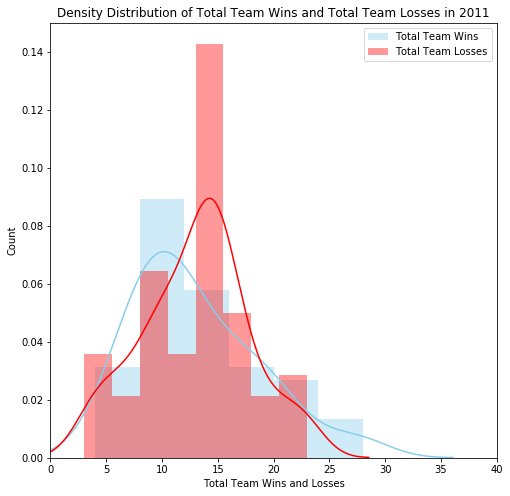

In [151]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
sns.distplot(df['totalwins'] , color="skyblue", label="High",)
sns.distplot(df['totalloss'] , color="red", label="Low",)

ax.legend(['Total Team Wins', 'Total Team Losses'])

ax.set(xlim=(0, 40))
ax.set_xlabel('Total Team Wins and Losses')
ax.set_ylabel('Count')
#plt.legend(fontsize='medium', title_fontsize='20')
plt.title('Density Distribution of Total Team Wins and Total Team Losses in 2011')

# plt.show()

## Getting the Weather Data
Note that for this last calculation, you'll need to figure out if it was raining or not during the game. The database itself does not contain this information, but it does contain the date on which the game was played. For this, you'll need to use the DarkSky API to get the historical weather data for that day. Note that each game is played in a different location, and this information is not contained in our SQL database. However, the teams in this database are largely german, so go ahead and just use the weather in Berlin, Germany as a proxy for this information. If it was raining in Berlin on the day the game was played, count that as rain game--you do not need to try and figure out the actual weather at each game's location, because we don't have that information!

- 5. The team's win percentage on days where it was raining during games in the 2011 season.


In [431]:
dfdate = pd.DataFrame(dfd.Date.unique())

In [432]:
dfdate.columns = ["Date"]

In [433]:
dfdate.head()

,Date
0,2011-07-15
1,2011-07-16
2,2011-07-17
3,2011-07-18
4,2011-07-22


In [428]:
import datetime
import time
import os


class WeatherGetter():

    def __init__(self, key_file, long, lat, datestring):
        self.api_key = os.environ[key_file]
        self.url_base = 'https://api.darksky.net/forecast/'
        self.long = long
        self.lat = lat
        self.dfd = datestring

    def get_unix(self, dateCol="Date"):
        # mktime assumes local time zone at 12am, germany is 6 hours ahead so it will be same day (6AM german time)
        self.dfd['unix_date'] = self.dfd[dateCol].apply(lambda s: str(
            round(time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple()))))
        return self.dfd

    def get_API(self):
        self.dfdapi = self.dfd.copy()
        self.dfdapi['url'] = self.url_base + self.api_key + '/' + \
            self.long + ',' + self.lat + ',' + self.dfdapi['unix_date']
        return self.dfdapi

    def get_rain(self):
        rain = []
        for element in self.dfdapi['url']:
            response = requests.get(element)
#           if response.status_code != 200:
#               return response.status_code
            soup = BeautifulSoup(response.text)
            par1 = soup.find_all('p')  # return back list
            par2 = par1[0]  # soup object inside list
            par3 = par2.contents[0]  # contents convert soup to text
            raini = json.loads(par3)
            rain.append(raini['daily']['data'][0]['precipIntensity'])
        self.dfd['Rain'] = rain
        return self.dfd

In [434]:
Berlin2011 = WeatherGetter("WEATHER_KEY", '52.5200', '13.4050', dfdate)

In [435]:
print(Berlin2011.api_key)
print(Berlin2011.url_base)
print(Berlin2011.long)
print(Berlin2011.lat)
print(Berlin2011.dfd)

cd35acf369b55daae38db9a2dd08b546
https://api.darksky.net/forecast/
52.5200
13.4050
           Date
0    2011-07-15
1    2011-07-16
2    2011-07-17
3    2011-07-18
4    2011-07-22
5    2011-07-23
6    2011-07-24
7    2011-07-25
8    2011-08-05
9    2011-08-06
10   2011-08-07
11   2011-08-08
12   2011-08-12
13   2011-08-13
14   2011-08-14
15   2011-08-15
16   2011-08-19
17   2011-08-20
18   2011-08-21
19   2011-08-22
20   2011-08-26
21   2011-08-27
22   2011-08-28
23   2011-08-29
24   2011-09-09
25   2011-09-10
26   2011-09-11
27   2011-09-12
28   2011-09-16
29   2011-09-17
..          ...
135  2012-03-30
136  2012-03-31
137  2012-04-01
138  2012-04-02
139  2012-04-05
140  2012-04-06
141  2012-04-07
142  2012-04-08
143  2012-04-09
144  2012-04-10
145  2012-04-11
146  2012-04-13
147  2012-04-14
148  2012-04-15
149  2012-04-16
150  2012-04-20
151  2012-04-21
152  2012-04-22
153  2012-04-23
154  2012-04-24
155  2012-04-28
156  2012-04-29
157  2012-04-30
158  2012-05-01
159  2012-05-02
160  

In [436]:
Berlin2011.get_unix("Date")

,Date,unix_date
0,2011-07-15,1310702400
1,2011-07-16,1310788800
2,2011-07-17,1310875200
3,2011-07-18,1310961600
4,2011-07-22,1311307200
5,2011-07-23,1311393600
6,2011-07-24,1311480000
7,2011-07-25,1311566400
8,2011-08-05,1312516800
9,2011-08-06,1312603200


In [437]:
dfdate

,Date,unix_date
0,2011-07-15,1310702400
1,2011-07-16,1310788800
2,2011-07-17,1310875200
3,2011-07-18,1310961600
4,2011-07-22,1311307200
5,2011-07-23,1311393600
6,2011-07-24,1311480000
7,2011-07-25,1311566400
8,2011-08-05,1312516800
9,2011-08-06,1312603200


In [438]:
Berlin2011.get_API()

,Date,unix_date,url
0,2011-07-15,1310702400,https://api.darksky.net/forecast/cd35acf369b55...
1,2011-07-16,1310788800,https://api.darksky.net/forecast/cd35acf369b55...
2,2011-07-17,1310875200,https://api.darksky.net/forecast/cd35acf369b55...
3,2011-07-18,1310961600,https://api.darksky.net/forecast/cd35acf369b55...
4,2011-07-22,1311307200,https://api.darksky.net/forecast/cd35acf369b55...
5,2011-07-23,1311393600,https://api.darksky.net/forecast/cd35acf369b55...
6,2011-07-24,1311480000,https://api.darksky.net/forecast/cd35acf369b55...
7,2011-07-25,1311566400,https://api.darksky.net/forecast/cd35acf369b55...
8,2011-08-05,1312516800,https://api.darksky.net/forecast/cd35acf369b55...
9,2011-08-06,1312603200,https://api.darksky.net/forecast/cd35acf369b55...


In [440]:
Berlin2011.get_rain()

,Date,unix_date,Rain
0,2011-07-15,1310702400,0.0000
1,2011-07-16,1310788800,0.0000
2,2011-07-17,1310875200,0.0180
3,2011-07-18,1310961600,0.0100
4,2011-07-22,1311307200,0.0489
5,2011-07-23,1311393600,0.0063
6,2011-07-24,1311480000,0.0000
7,2011-07-25,1311566400,0.0000
8,2011-08-05,1312516800,0.0047
9,2011-08-06,1312603200,0.0017


In [441]:
dfdate

,Date,unix_date,Rain
0,2011-07-15,1310702400,0.0000
1,2011-07-16,1310788800,0.0000
2,2011-07-17,1310875200,0.0180
3,2011-07-18,1310961600,0.0100
4,2011-07-22,1311307200,0.0489
5,2011-07-23,1311393600,0.0063
6,2011-07-24,1311480000,0.0000
7,2011-07-25,1311566400,0.0000
8,2011-08-05,1312516800,0.0047
9,2011-08-06,1312603200,0.0017


In [185]:
len(dfm)

992

In [442]:
dfall = dfm.merge(dfdate, left_on='Date', right_on = 'Date', how= 'left')
len(dfall)

992

In [443]:
dfall.head(10)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,unix_date,Rain
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H,1310702400,0.0000
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A,1310702400,0.0000
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D,1310702400,0.0000
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H,1310788800,0.0000
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H,1310788800,0.0000
5,1146,D2,2011,2011-07-17,Karlsruhe,Duisburg,3,2,H,1310875200,0.0180
6,1442,D2,2011,2011-07-17,Braunschweig,Munich 1860,3,1,H,1310875200,0.0180
7,1602,D2,2011,2011-07-17,Hansa Rostock,Paderborn,1,2,A,1310875200,0.0180
8,1360,D2,2011,2011-07-18,Fortuna Dusseldorf,Bochum,2,0,H,1310961600,0.0100
9,1505,D2,2011,2011-07-22,Duisburg,Cottbus,1,2,A,1311307200,0.0489


In [444]:
dfallr = dfall[(dfall['Rain']>0)]

In [446]:
dfallr.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,unix_date,Rain
5,1146,D2,2011,2011-07-17,Karlsruhe,Duisburg,3,2,H,1310875200,0.0180
6,1442,D2,2011,2011-07-17,Braunschweig,Munich 1860,3,1,H,1310875200,0.0180
7,1602,D2,2011,2011-07-17,Hansa Rostock,Paderborn,1,2,A,1310875200,0.0180
8,1360,D2,2011,2011-07-18,Fortuna Dusseldorf,Bochum,2,0,H,1310961600,0.0100
9,1505,D2,2011,2011-07-22,Duisburg,Cottbus,1,2,A,1311307200,0.0489


In [447]:
dfallah = pd.DataFrame(dfallr.groupby('HomeTeam')['HomeTeam'].count())

In [448]:
dfallah.columns = ['HomeGameTot']

In [449]:
dfallah

,HomeGameTot
HomeTeam,
Aachen,5
Arsenal,9
Aston Villa,9
Augsburg,7
Bayern Munich,4
Blackburn,7
Bochum,5
Bolton,6
Braunschweig,4


In [450]:
dfallah['AwayGameTot']=dfallr.groupby('AwayTeam')['AwayTeam'].count()

In [451]:
dfallah

,HomeGameTot,AwayGameTot
HomeTeam,,
Aachen,5,8
Arsenal,9,5
Aston Villa,9,3
Augsburg,7,4
Bayern Munich,4,7
Blackburn,7,3
Bochum,5,6
Bolton,6,6
Braunschweig,4,5


In [457]:
dfallhw = dfall[(dfall['Rain']>0) & (dfall['FTR']=='H')]

In [458]:
dfallhw.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,unix_date,Rain
5,1146,D2,2011,2011-07-17,Karlsruhe,Duisburg,3,2,H,1310875200,0.0180
6,1442,D2,2011,2011-07-17,Braunschweig,Munich 1860,3,1,H,1310875200,0.0180
8,1360,D2,2011,2011-07-18,Fortuna Dusseldorf,Bochum,2,0,H,1310961600,0.0100
11,1667,D2,2011,2011-07-22,Bochum,Frankfurt FSV,1,0,H,1311307200,0.0489
12,1261,D2,2011,2011-07-23,Munich 1860,Karlsruhe,2,1,H,1311393600,0.0063


In [459]:
dfallaw = dfall[(dfall['Rain']>0) & (dfall['FTR']=='A')]

In [460]:
dfallah['HomeWins'] = dfallhw.groupby('HomeTeam')['FTR'].count()

In [461]:
dfallah['AwayWins'] = dfallaw.groupby('AwayTeam')['FTR'].count()

In [462]:
dfallah.fillna(0, inplace = True)

In [471]:
dfallah['RainWinShare'] = round((dfallah['HomeWins']+dfallah['AwayWins'])/(dfallah['HomeGameTot'] + dfallah['AwayGameTot']),2)



In [472]:
dfallah

,HomeGameTot,AwayGameTot,HomeWins,AwayWins,RainWinShare
HomeTeam,,,,,
Aachen,5,8,1.0,2.0,0.23
Arsenal,9,5,6.0,2.0,0.57
Aston Villa,9,3,1.0,1.0,0.17
Augsburg,7,4,4.0,0.0,0.36
Bayern Munich,4,7,3.0,5.0,0.73
Blackburn,7,3,1.0,0.0,0.10
Bochum,5,6,1.0,2.0,0.27
Bolton,6,6,1.0,3.0,0.33
Braunschweig,4,5,2.0,2.0,0.44


In [474]:
df_final = df.merge(dfallah, left_on='teamnames', right_on = 'HomeTeam', how= 'left')
df_final.head()


,id,teamnames,homegoals,awaygoals,homewins,awaywins,homelosses,awaylosses,totalgoals,totalwins,totalloss,HomeGameTot,AwayGameTot,HomeWins,AwayWins,RainWinShare
0,1,Aachen,15,15,4,2,7,8,30,6,15,5.0,8.0,1.0,2.0,0.23
1,2,Arsenal,39,35,12,9,3,7,74,21,10,9.0,5.0,6.0,2.0,0.57
2,3,Aston Villa,20,17,4,3,8,6,37,7,14,9.0,3.0,1.0,1.0,0.17
3,4,Augsburg,20,16,6,2,4,8,36,8,12,7.0,4.0,4.0,0.0,0.36
4,5,Bayern Munich,49,28,14,9,2,5,77,23,7,4.0,7.0,3.0,5.0,0.73


In [276]:
teams, hg, ag, hw, aw, hl, al, rainwin

['Aachen',
 'Arsenal',
 'Aston Villa',
 'Augsburg',
 'Bayern Munich',
 'Blackburn',
 'Bochum',
 'Bolton',
 'Braunschweig',
 'Chelsea',
 'Cottbus',
 'Dortmund',
 'Dresden',
 'Duisburg',
 'Ein Frankfurt',
 'Erzgebirge Aue',
 'Everton',
 'FC Koln',
 'Fortuna Dusseldorf',
 'Frankfurt FSV',
 'Freiburg',
 'Fulham',
 'Greuther Furth',
 'Hamburg',
 'Hannover',
 'Hansa Rostock',
 'Hertha',
 'Hoffenheim',
 'Ingolstadt',
 'Kaiserslautern',
 'Karlsruhe',
 'Leverkusen',
 'Liverpool',
 "M''gladbach",
 'Mainz',
 'Man City',
 'Man United',
 'Munich 1860',
 'Newcastle',
 'Norwich',
 'Nurnberg',
 'Paderborn',
 'QPR',
 'Schalke 04',
 'St Pauli',
 'Stoke',
 'Stuttgart',
 'Sunderland',
 'Swansea',
 'Tottenham',
 'Union Berlin',
 'Werder Bremen',
 'West Brom',
 'Wigan',
 'Wolfsburg',
 'Wolves']

In [293]:
teams

['Aachen',
 'Arsenal',
 'Aston Villa',
 'Augsburg',
 'Bayern Munich',
 'Blackburn',
 'Bochum',
 'Bolton',
 'Braunschweig',
 'Chelsea',
 'Cottbus',
 'Dortmund',
 'Dresden',
 'Duisburg',
 'Ein Frankfurt',
 'Erzgebirge Aue',
 'Everton',
 'FC Koln',
 'Fortuna Dusseldorf',
 'Frankfurt FSV',
 'Freiburg',
 'Fulham',
 'Greuther Furth',
 'Hamburg',
 'Hannover',
 'Hansa Rostock',
 'Hertha',
 'Hoffenheim',
 'Ingolstadt',
 'Kaiserslautern',
 'Karlsruhe',
 'Leverkusen',
 'Liverpool',
 "M''gladbach",
 'Mainz',
 'Man City',
 'Man United',
 'Munich 1860',
 'Newcastle',
 'Norwich',
 'Nurnberg',
 'Paderborn',
 'QPR',
 'Schalke 04',
 'St Pauli',
 'Stoke',
 'Stuttgart',
 'Sunderland',
 'Swansea',
 'Tottenham',
 'Union Berlin',
 'Werder Bremen',
 'West Brom',
 'Wigan',
 'Wolfsburg',
 'Wolves']

In [286]:
tg = list(df_final['totalgoals'])
tg

[30,
 74,
 37,
 36,
 77,
 48,
 41,
 46,
 37,
 65,
 30,
 80,
 50,
 42,
 76,
 31,
 50,
 39,
 64,
 43,
 45,
 48,
 73,
 35,
 41,
 34,
 38,
 41,
 43,
 24,
 34,
 52,
 47,
 49,
 47,
 93,
 89,
 62,
 56,
 52,
 38,
 51,
 43,
 74,
 59,
 36,
 63,
 45,
 44,
 66,
 55,
 49,
 45,
 42,
 47,
 40]

In [287]:
tw = list(df_final['totalwins'])
tw

[6,
 21,
 7,
 8,
 23,
 8,
 10,
 10,
 10,
 18,
 8,
 25,
 12,
 10,
 20,
 8,
 15,
 8,
 16,
 7,
 10,
 14,
 20,
 8,
 12,
 5,
 7,
 10,
 8,
 4,
 9,
 15,
 14,
 17,
 9,
 28,
 28,
 17,
 19,
 12,
 12,
 17,
 10,
 20,
 18,
 11,
 15,
 11,
 12,
 20,
 14,
 11,
 13,
 11,
 13,
 5]

In [477]:
rainwin = list(dfallah['RainWinShare'])

In [478]:
all_results = []
for i in range(0,len(teams)):
    all_results.append({'team_name': teams[i], 'total_goals': tg[i], 'total_wins': tw[i], 'Wins_in_rain_share': rainwin[i]})

In [479]:
all_results

[{'team_name': 'Aachen',
  'total_goals': 30,
  'total_wins': 6,
  'Wins_in_rain_share': 0.23},
 {'team_name': 'Arsenal',
  'total_goals': 74,
  'total_wins': 21,
  'Wins_in_rain_share': 0.57},
 {'team_name': 'Aston Villa',
  'total_goals': 37,
  'total_wins': 7,
  'Wins_in_rain_share': 0.17},
 {'team_name': 'Augsburg',
  'total_goals': 36,
  'total_wins': 8,
  'Wins_in_rain_share': 0.36},
 {'team_name': 'Bayern Munich',
  'total_goals': 77,
  'total_wins': 23,
  'Wins_in_rain_share': 0.73},
 {'team_name': 'Blackburn',
  'total_goals': 48,
  'total_wins': 8,
  'Wins_in_rain_share': 0.1},
 {'team_name': 'Bochum',
  'total_goals': 41,
  'total_wins': 10,
  'Wins_in_rain_share': 0.27},
 {'team_name': 'Bolton',
  'total_goals': 46,
  'total_wins': 10,
  'Wins_in_rain_share': 0.33},
 {'team_name': 'Braunschweig',
  'total_goals': 37,
  'total_wins': 10,
  'Wins_in_rain_share': 0.44},
 {'team_name': 'Chelsea',
  'total_goals': 65,
  'total_wins': 18,
  'Wins_in_rain_share': 0.57},
 {'team_na

## Mongo

In [486]:
import pymongo
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['mod2proj_final']

In [487]:
mycol = mydb['mod2proj_final']

In [488]:
all_results

[{'team_name': 'Aachen',
  'total_goals': 30,
  'total_wins': 6,
  'Wins_in_rain_share': 0.23,
  '_id': ObjectId('5d19de9272c76097af05913c')},
 {'team_name': 'Arsenal',
  'total_goals': 74,
  'total_wins': 21,
  'Wins_in_rain_share': 0.57,
  '_id': ObjectId('5d19de9272c76097af05913d')},
 {'team_name': 'Aston Villa',
  'total_goals': 37,
  'total_wins': 7,
  'Wins_in_rain_share': 0.17,
  '_id': ObjectId('5d19de9272c76097af05913e')},
 {'team_name': 'Augsburg',
  'total_goals': 36,
  'total_wins': 8,
  'Wins_in_rain_share': 0.36,
  '_id': ObjectId('5d19de9272c76097af05913f')},
 {'team_name': 'Bayern Munich',
  'total_goals': 77,
  'total_wins': 23,
  'Wins_in_rain_share': 0.73,
  '_id': ObjectId('5d19de9272c76097af059140')},
 {'team_name': 'Blackburn',
  'total_goals': 48,
  'total_wins': 8,
  'Wins_in_rain_share': 0.1,
  '_id': ObjectId('5d19de9272c76097af059141')},
 {'team_name': 'Bochum',
  'total_goals': 41,
  'total_wins': 10,
  'Wins_in_rain_share': 0.27,
  '_id': ObjectId('5d19de92

In [489]:
insertion_results = mycol.insert_many(all_results)

In [490]:
insertion_results.inserted_ids

[ObjectId('5d19de9272c76097af05913c'),
 ObjectId('5d19de9272c76097af05913d'),
 ObjectId('5d19de9272c76097af05913e'),
 ObjectId('5d19de9272c76097af05913f'),
 ObjectId('5d19de9272c76097af059140'),
 ObjectId('5d19de9272c76097af059141'),
 ObjectId('5d19de9272c76097af059142'),
 ObjectId('5d19de9272c76097af059143'),
 ObjectId('5d19de9272c76097af059144'),
 ObjectId('5d19de9272c76097af059145'),
 ObjectId('5d19de9272c76097af059146'),
 ObjectId('5d19de9272c76097af059147'),
 ObjectId('5d19de9272c76097af059148'),
 ObjectId('5d19de9272c76097af059149'),
 ObjectId('5d19de9272c76097af05914a'),
 ObjectId('5d19de9272c76097af05914b'),
 ObjectId('5d19de9272c76097af05914c'),
 ObjectId('5d19de9272c76097af05914d'),
 ObjectId('5d19de9272c76097af05914e'),
 ObjectId('5d19de9272c76097af05914f'),
 ObjectId('5d19de9272c76097af059150'),
 ObjectId('5d19de9272c76097af059151'),
 ObjectId('5d19de9272c76097af059152'),
 ObjectId('5d19de9272c76097af059153'),
 ObjectId('5d19de9272c76097af059154'),
 ObjectId('5d19de9272c760

In [491]:
query_1 = mycol.find({})
for x in query_1:
    print(x)

{'_id': ObjectId('5d19de9272c76097af05913c'), 'team_name': 'Aachen', 'total_goals': 30, 'total_wins': 6, 'Wins_in_rain_share': 0.23}
{'_id': ObjectId('5d19de9272c76097af05913d'), 'team_name': 'Arsenal', 'total_goals': 74, 'total_wins': 21, 'Wins_in_rain_share': 0.57}
{'_id': ObjectId('5d19de9272c76097af05913e'), 'team_name': 'Aston Villa', 'total_goals': 37, 'total_wins': 7, 'Wins_in_rain_share': 0.17}
{'_id': ObjectId('5d19de9272c76097af05913f'), 'team_name': 'Augsburg', 'total_goals': 36, 'total_wins': 8, 'Wins_in_rain_share': 0.36}
{'_id': ObjectId('5d19de9272c76097af059140'), 'team_name': 'Bayern Munich', 'total_goals': 77, 'total_wins': 23, 'Wins_in_rain_share': 0.73}
{'_id': ObjectId('5d19de9272c76097af059141'), 'team_name': 'Blackburn', 'total_goals': 48, 'total_wins': 8, 'Wins_in_rain_share': 0.1}
{'_id': ObjectId('5d19de9272c76097af059142'), 'team_name': 'Bochum', 'total_goals': 41, 'total_wins': 10, 'Wins_in_rain_share': 0.27}
{'_id': ObjectId('5d19de9272c76097af059143'), 'te

In [492]:
resp = requests.get('https://github.com/phoebetwong/flatiron_mod2proj/blob/phoebe/histgraph.png')
img = resp.content

In [493]:
img

b'\n\n\n\n\n\n<!DOCTYPE html>\n<html lang="en">\n  <head>\n    <meta charset="utf-8">\n  <link rel="dns-prefetch" href="https://github.githubassets.com">\n  <link rel="dns-prefetch" href="https://avatars0.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://avatars1.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://avatars2.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://avatars3.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">\n  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">\n\n\n\n  <link crossorigin="anonymous" media="all" integrity="sha512-67V2J9Se2CifJlftk9/cExHGvxd7N9b9EdGnQEpszu99Ogeecilu9jIDxoCkx3zNLfB9ArraXW0J03qyVmN0Uw==" rel="stylesheet" href="https://github.githubassets.com/assets/frameworks-e7318add1f7e055d040edb0f75aaa0ba.css" />\n  <link crossorigin="anonymous" media="all" integrity="sha512-MRlTIqIyb8caK5+o8llXVntXovciHyAM4qE3kWU2S7SIjAPDxYp4mE0jQ

In [494]:
newdict = {'a':4, 'image': img}
mycol.insert_one(newdict)

In [495]:
_.inserted_id

ObjectId('5d19df1f72c76097af059175')

# NOTES

In [20]:
s = 'abc12321cba'

print(s.translate({ord(i): None for i in 'abc'}))

12321


In [87]:
tname = []
for t in tables:
    newt = t[0].translate({ord(i): None for i in '(),'})
    tname.append(newt)
tname

['sqlite_sequence', 'Matches', 'Teams_in_Matches', 'Teams', 'Unique_Teams']

In [39]:
for t in tables:
    print(t[0])
    c.execute(f"'''select * from {t[0]};'''")
    print(c.description)

sqlite_sequence


OperationalError: near "'''select * from sqlite_sequence;'''": syntax error

In [234]:
pd.DataFrame(dfall.groupby('HomeTeam')['rdum'].sum())

,rdum
HomeTeam,
Aachen,5.0
Arsenal,9.0
Aston Villa,9.0
Augsburg,7.0
Bayern Munich,4.0
Blackburn,7.0
Bochum,5.0
Bolton,6.0
Braunschweig,4.0
